In [18]:
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms, models as torchvision_models
from torch.utils.data import Dataset, DataLoader
import timm
import pandas as pd
from PIL import Image
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
from diffusers import StableDiffusionPipeline, AutoencoderKL, DiffusionPipeline

from torchvision.models import vgg16

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return 1000
        # return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))

class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

def color_histogram_loss(output, target, bins=256, min_value=0, max_value=1):
    hist_loss = 0.0
    for channel in range(3):
        output_hist = torch.histc(output[:, channel, :, :], bins=bins, min=min_value, max=max_value)
        target_hist = torch.histc(target[:, channel, :, :], bins=bins, min=min_value, max=max_value)
        output_hist /= output_hist.sum()
        target_hist /= target_hist.sum()
        hist_loss += torch.norm(output_hist - target_hist, p=2)
    return hist_loss / 3

class Colorizer(LightningModule):
    def __init__(self, vae):
        super().__init__()
        self.model = vae
        vgg_model = vgg16(weights=True)
        self.loss_fn = VGGPerceptualLoss(vgg_model)
        self.hparams.learning_rate = 0.000001

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs).sample
        perceptual_loss = self.loss_fn(outputs, targets)
        histogram_loss = color_histogram_loss(outputs, targets)
        total_loss = perceptual_loss + histogram_loss  # You can also use weights here if needed
        self.log('train_loss', total_loss)
        self.log('perceptual_loss', perceptual_loss)
        self.log('histogram_loss', histogram_loss)
        return total_loss

In [3]:
data_folder = 'data/toy'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=1)

In [25]:
idx = 1
x, y = training_dataset[idx]

In [26]:
from torchvision.utils import make_grid

def view_image_and_histogram(dataset, idx):
    """
    Fetch an image by index from the dataset and plot the image and its color histograms.
    
    Parameters:
    - dataset: a PyTorch Dataset object that returns images as tensors
    - idx: Index of the image in the dataset
    
    """
    # Fetch the image
    image = dataset[idx]
    
    # Assuming the dataset returns a tuple (image, target), if not adjust accordingly
    if isinstance(image, tuple):
        image = image[1]
    
    # Normalize image for display
    image_display = image.clone().detach()
    image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())
    
    # Plotting the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    grid_img = make_grid(image_display, nrow=1)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title('Image')
    plt.axis('off')
    
    # Plotting the histogram
    plt.subplot(1, 2, 2)
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        histogram, bin_edges = torch.histogram(image[i], bins=256, range=(0, 1))
        plt.plot(bin_edges[:-1], histogram, color=color)
    
    plt.title('Color Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

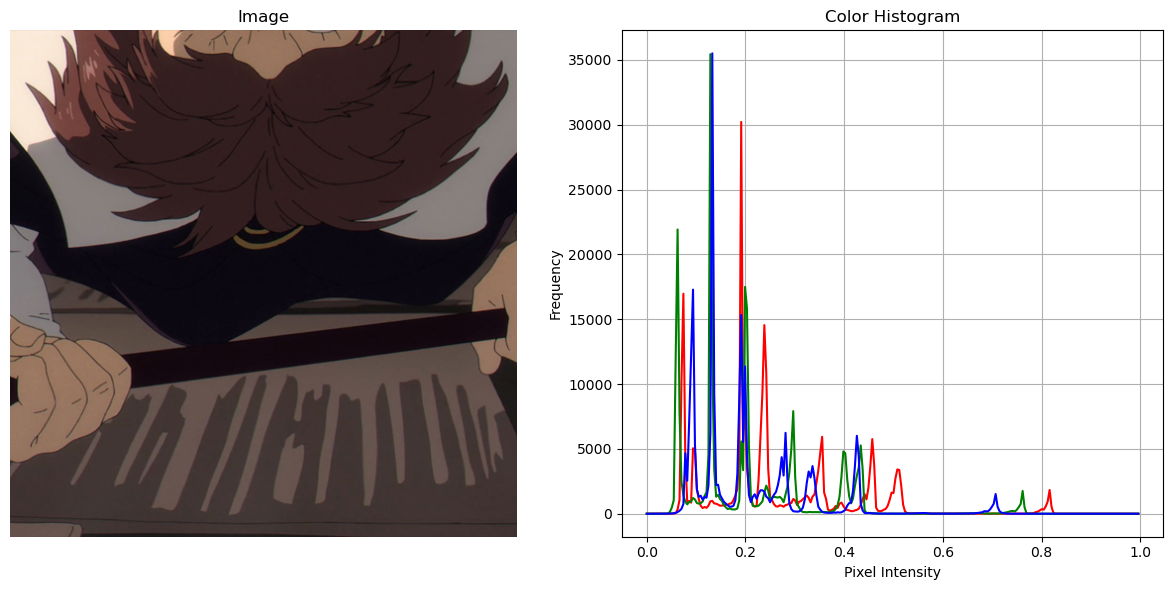

In [32]:
view_image_and_histogram(training_dataset, 5)

TypeError: Invalid shape (256,) for image data

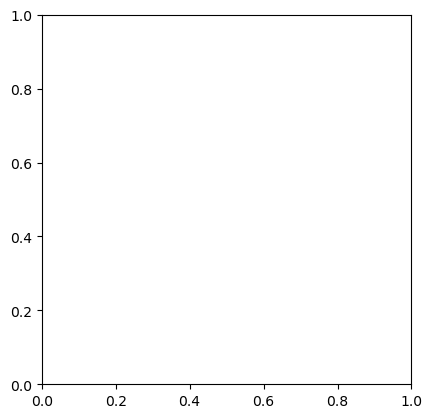

In [19]:
plt.imshow(torch.histc(y[1, :, :], bins=256, min=0, max=1))

In [10]:
y.shape

torch.Size([3, 512, 512])